Document for Model training



Importing packages

In [1]:
import skimage
from TreeLib import Tree
from TreeLib import drawTree, genTree
from genInputFromLabel import labelToInput


Setting Constants

In [2]:
startX = 5
startY = 360
startAngle = 0
starWidth = 15
stopWidth = 3
startLength = 20
bifurcProb = 0.3

Synthetic Angiogram Class: Node

Synthetic Angiogram Class: Tree

Drawing Tree

Executing

In [3]:
tree = Tree(startX, startY, starWidth, startLength, startAngle, stopWidth)
#synAngio = genTree(tree, (736, 736))
#drawTree(synAngio, lab=True)

for i in range(100):
    tree = Tree(startX, startY, starWidth,startLength, startAngle,stopWidth, bifurcProb=bifurcProb, angleStdMul=0.05)
    synAngioLab = genTree(tree, (736, 736))
    synAngioInput = labelToInput(synAngioLab)
    #drawTree(synAngioLab, lab=True)
    #drawTree(synAngioInput)

In [7]:
from saveSynData import genSynDat

lst = [startX, startY, starWidth, startLength, startAngle, stopWidth]

genSynDat("SynDat/", lst, (736, 736), 2)

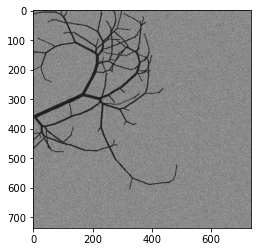